In [83]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

from keras.models import load_model

In [84]:
look_back = 200
forward_days = 180
num_periods = 4
targetmonth= 9
X1,Y1,X2,Y2 = [],[],[],[]

First, just open the CSV using Pandas, set the Date as index and keep only the Closing Price column.

In [61]:
"""
#Test section
dfinitial = pd.read_csv('corn_barchart_new.csv')
df=dfinitial[dfinitial['month']==month]
_df3 = df[df['year']==2010]
_df3['date'] = pd.to_datetime(_df3['date'])
_df3.set_index('date', inplace=True)
_df3.sort_index(axis = 0)
n=2
df3=_df3.head(n)
df3 = df3[::-1]
print(df3)
#_dfx = _df3['day']
#array1 = _dfx.values.reshape(_dfx.shape[0],1)
#array1[0:5]
"""

            year  month    open   close  open_net  close_net  open_rel  \
date                                                                     
2010-09-13  2010      9  463.25  469.25    -14.75      -8.75  0.969142   
2010-09-14  2010      9  470.00  478.00     -8.00       0.00  0.983264   

            close_rel  volume  openint  day  
date                                         
2010-09-13   0.981695    7972     1913    1  
2010-09-14   1.000000    2642        0    0  


<ipython-input-61-6071b700522e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df3['date'] = pd.to_datetime(_df3['date'])


In [85]:
#to be changed
#open the csv, chose company_N, where N = {A, B, C or D}
dfinitial = pd.read_csv('corn_barchart_new.csv')

#_y = data['year'].drop_duplicates().sort_values()
#years = data['year'].unique()
#years = pd.unique(_df['year'])
#years.sort()

for month in (3,5,7,9,12):
    df=dfinitial[dfinitial['month']==month]
    for year in range(2003,2018):
        _df2 = df[df['year']==year]
        _df2['date'] = pd.to_datetime(_df2['date'])
        _df2.set_index('date', inplace=True)
        _df2.sort_index(axis = 0)
        n = look_back + forward_days
        _df2=_df2.head(n)
        _df2 = _df2[::-1]
        #keep only the 'close' column
        _df2 = _df2['close']
        
        #Data normalization
        array = _df2.values.reshape(_df2.shape[0],1)
        from sklearn.preprocessing import MinMaxScaler
        scl = MinMaxScaler()
        array = scl.fit_transform(array)
        
        #Get the data and splits in input X and output Y, by spliting in `look_back` past days as
        #input X and `forward_days` coming days as Y.
        X1.append(array[0:look_back])
        Y1.append(array[look_back:(look_back+forward_days)])

X = np.array(X1)
y = np.array(Y1)
y = np.array([list(a.ravel()) for a in y])

df=dfinitial[dfinitial['month']==targetmonth]
for year in range(2018,2020):
    _df2 = df[df['year']==year]
    _df2['date'] = pd.to_datetime(_df2['date'])
    _df2.set_index('date', inplace=True)
    _df2.sort_index(axis = 0)
    n = look_back + forward_days
    _df2=_df2.head(n)
    _df2 = _df2[::-1]
    #keep only the 'Close' column
    _df2 = _df2['close']
    array = _df2.values.reshape(_df2.shape[0],1)
    from sklearn.preprocessing import MinMaxScaler
    scl = MinMaxScaler()
    array = scl.fit_transform(array)
    X2.append(array[0:look_back])
    Y2.append(array[look_back:(look_back+forward_days)])

X_test = np.array(X2)
y_test  = np.array(Y2)
y_test  = np.array([list(a.ravel()) for a in y_test ])

#Split the data in Data to Train/Validate the LSTM and Data to Test the model

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)



<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['date'] = pd.to_datetime(_df2['date'])
<ipython-input-85-4267927bdf37>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [86]:
#VERIFYING
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(60, 200, 1)
(15, 200, 1)
(2, 200, 1)
(60, 180)
(15, 180)
(2, 180)



**Training the LSTM**

In [87]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 100

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 60 samples, validate on 15 samples
Epoch 1/100
 - 7s - loss: 0.1628 - val_loss: 0.1035
Epoch 2/100
 - 6s - loss: 0.0740 - val_loss: 0.0723
Epoch 3/100
 - 6s - loss: 0.0675 - val_loss: 0.0722
Epoch 4/100
 - 6s - loss: 0.0661 - val_loss: 0.0721
Epoch 5/100
 - 6s - loss: 0.0650 - val_loss: 0.0783
Epoch 6/100
 - 7s - loss: 0.0669 - val_loss: 0.0750
Epoch 7/100
 - 6s - loss: 0.0657 - val_loss: 0.0750
Epoch 8/100
 - 6s - loss: 0.0643 - val_loss: 0.0722
Epoch 9/100
 - 6s - loss: 0.0634 - val_loss: 0.0720
Epoch 10/100
 - 6s - loss: 0.0635 - val_loss: 0.0743
Epoch 11/100
 - 6s - loss: 0.0628 - val_loss: 0.0781
Epoch 12/100
 - 6s - loss: 0.0657 - val_loss: 0.0711
Epoch 13/100
 - 6s - loss: 0.0625 - val_loss: 0.0730
Epoch 14/100
 - 6s - loss: 0.0637 - val_loss: 0.0720
Epoch 15/100
 - 6s - loss: 0.0631 - val_loss: 0.0720
Epoch 16/100
 - 6s - loss: 0.0646 - val_loss: 0.0721
Epoch 17/100
 - 6s - loss: 0.0611 - val_loss: 0.0693
Epoch 18/100
 - 6s - loss: 0.0609 - val_loss: 0.0684
Epoch 19/10

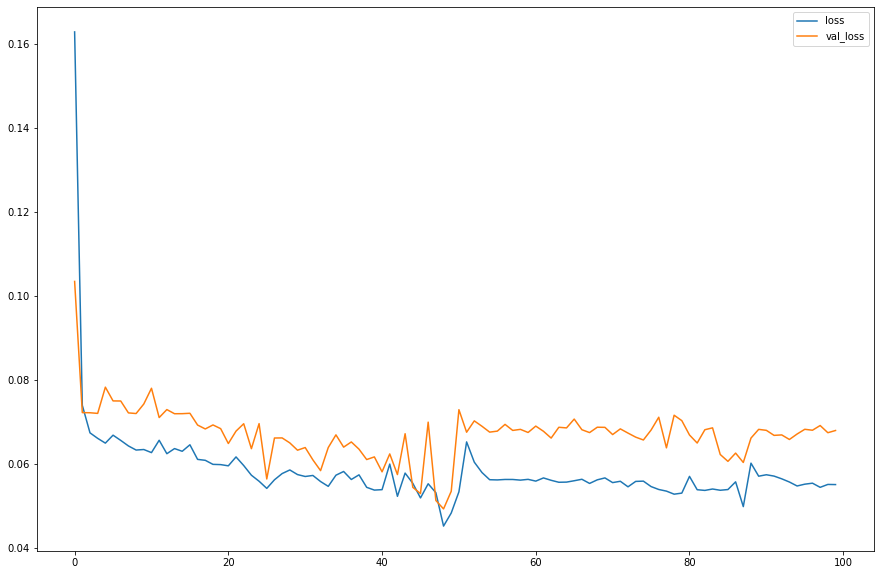

In [88]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

**Predicting the Test Set to see the results**

In [89]:
Xt = model.predict(X_test)
print(len(Xt))
print(Xt.shape)

2
(2, 180)


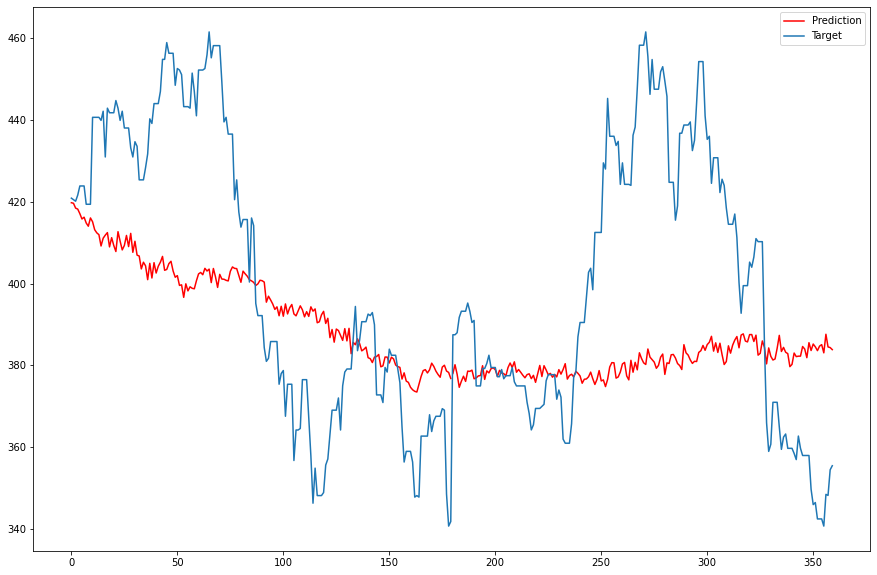

In [90]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()